<a href="https://colab.research.google.com/github/LukasEder1/DeepLearning/blob/main/Assignment2/exercise3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


# Assignment 2 - Exercise 3:
*   Improve the accuracy of the finetuned model
    *    Tune conv layers in addition to the fc layers
    *    Instead of replacing all fc layers, replace the last one
    *    Train for more epochs
    *    Try out different batch sizes, optimizers, learning rates
    *    Finetune a different network such as AlexNet or ResNet
*   Visualize filter (kernel) weights
*   Visualize activations

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models, utils
import matplotlib.pyplot as plt
import numpy as np
# To avoid the error URLError:<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed
import ssl
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Important Resize Iamges to 224, 224

In [29]:
# Output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Create the data loaders for the train and test sets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=False, num_workers=2)

# The 10 classes of CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


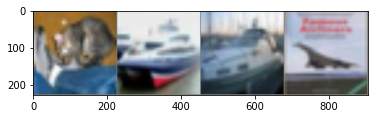

GroundTruth:    cat


In [5]:
# Check the testset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)

# print images
imshow(torchvision.utils.make_grid(images.cpu()))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(1)))

## Finetuning

https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#resnet

In [30]:

# Create a vgg16 network with pretrained weights (trained on ImageNet)
model_vgg11 = models.vgg11_bn(pretrained=True).to(device)
#model_res18 = models.resnet18(pretrained=True).to(device)

# Setup VGG16

In [31]:
# Prevent the trained weights from being modified
for param in model_vgg11.features.parameters():
    param.requires_grad = False

# Compute the input feature size for the first fc layer
num_ftrs = list(model_vgg11.classifier.children())[0].in_features
print(num_ftrs)

classifier = list(model_vgg11.classifier.children())[:-1] # Remove last layer
#classifier.extend([nn.Linear(num_ftrs, len(classes)).to(device)]) # Add our layer with 10 outputs

# Create a new set of fc layers
"""
classifier = [nn.Linear(in_features=num_ftrs, out_features=4096).to(device), 
              nn.ReLU(inplace=True).to(device), 
              nn.Dropout(p=0.5, inplace=False).to(device), 
              nn.Linear(in_features=4096, out_features=2048).to(device), 
              nn.ReLU(inplace=True).to(device), 
              nn.Dropout(p=0.5, inplace=False).to(device),
              nn.Linear(in_features=2048, out_features=1024).to(device), 
              nn.ReLU(inplace=True).to(device), 
              nn.Dropout(p=0.5, inplace=False).to(device),
              nn.Linear(in_features=1024, out_features=len(classes), bias=True).to(device)]


model_vgg16.classifier = nn.Sequential(*classifier) # Replace the model classifier
"""

#last
model_vgg11.classifier[6] = nn.Linear(4096, len(classes))

print(model_vgg11)

25088
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPoo

Setup ResNEt

In [ ]:
for param in model_res18.parameters():
    param.requires_grad = False

model_res18.fc = nn.Linear(512, len(classes))

In [39]:
summary(m.cuda(), (3, 32, 32)) # Input size: (channels, height, width of image)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
         MaxPool2d-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         295,168
      BatchNorm2d-10            [-1, 256, 8, 8]             512
             ReLU-11            [-1, 256, 8, 8]               0
           Conv2d-12            [-1, 256, 8, 8]         590,080
      BatchNorm2d-13            [-1, 256, 8, 8]             512
             ReLU-14            [-1, 25

In [32]:
m = model_vgg11.to(device)

In [33]:
# Define the loss and the optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(m.parameters(), lr=0.01)

In [34]:
m.train()
for epoch in range(4):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = m(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.781
[1,  4000] loss: 0.594
[1,  6000] loss: 0.545
[2,  2000] loss: 0.381
[2,  4000] loss: 0.368
[2,  6000] loss: 0.373
[3,  2000] loss: 0.238
[3,  4000] loss: 0.261
[3,  6000] loss: 0.256
[4,  2000] loss: 0.166
[4,  4000] loss: 0.167
[4,  6000] loss: 0.177
Finished Training


Save Trained Model for future use cases

In [35]:
PATH = 'last_resized011.pth'
torch.save(m.state_dict(), PATH)

In [36]:
%cp "/content/last_resized011.pth" "/content/gdrive/MyDrive"

In [37]:
def load_model(path, mod):
    # Load the saved weights and create the network
    model = mod.to(device)
    model.load_state_dict(torch.load(PATH))
    
    return model

model = load_model("last_resized011.pth", m)

# Evaluate the models accuracy

In [38]:
 # Check the accuracy of the finetuned network on the test set#
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 87 %


# Visualize Kernels

In [ ]:
no_of_layers=0
conv_layers=[]
 
model_children=list(model.children())
 
for child in model_children:
  if type(child)==nn.Conv2d:
    no_of_layers+=1
    conv_layers.append(child)
  elif type(child)==nn.Sequential:
    for layer in child.children():
      if type(layer)==nn.Conv2d:
        no_of_layers+=1
        conv_layers.append(layer)
print(no_of_layers)

8


In [ ]:
conv_layers

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]

Code taken from: https://stackoverflow.com/questions/55594969/how-to-visualise-filters-in-a-cnn-with-pytorch

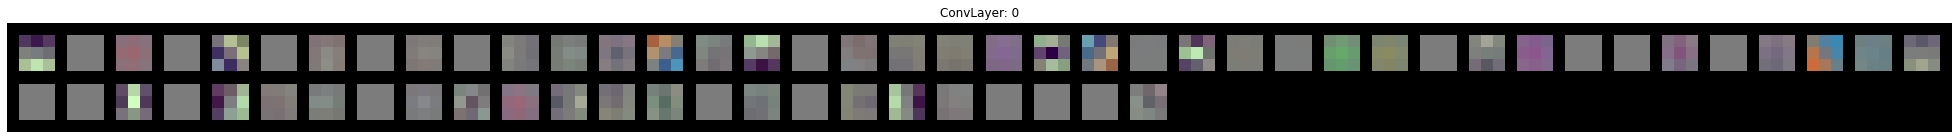

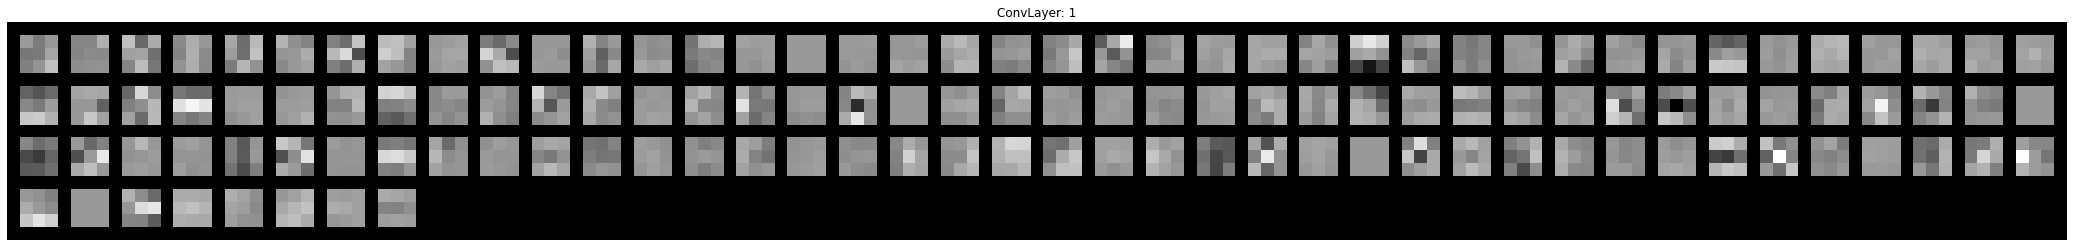

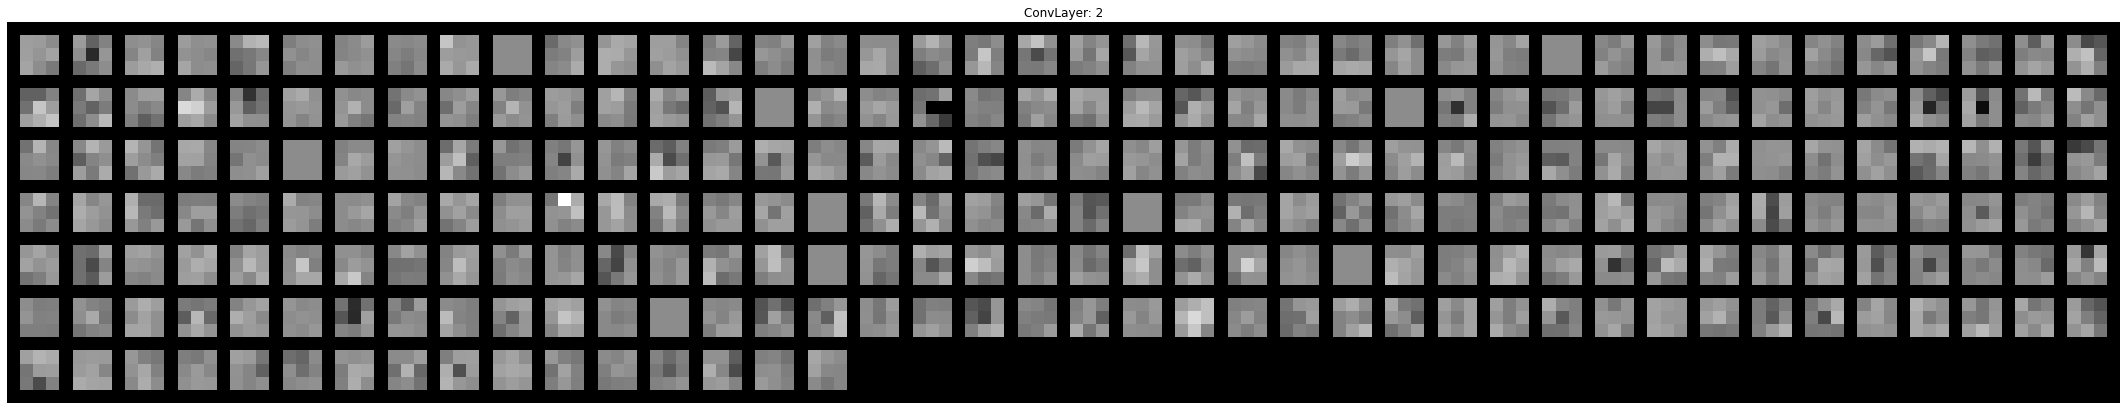

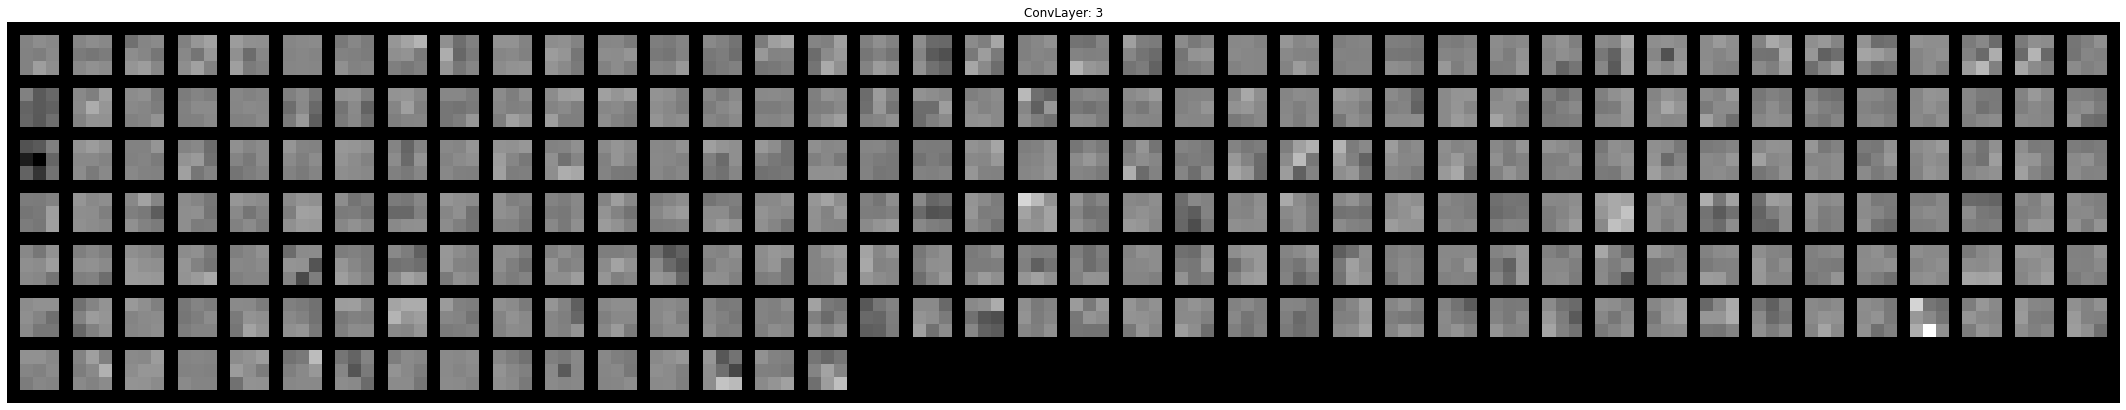

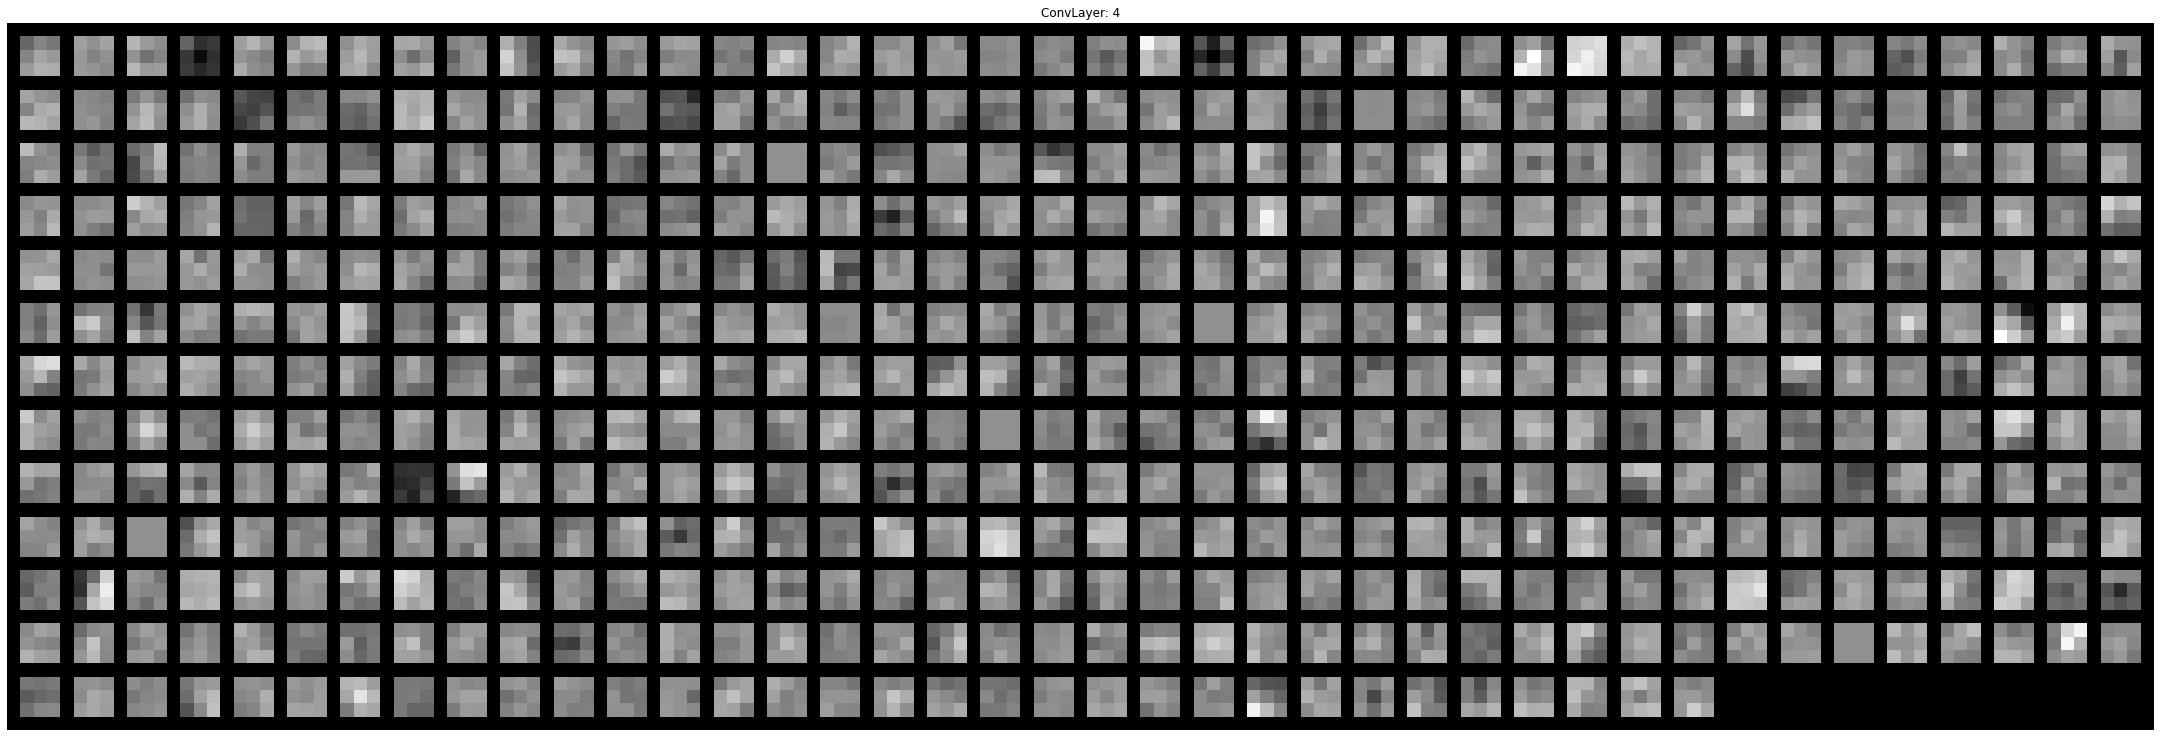

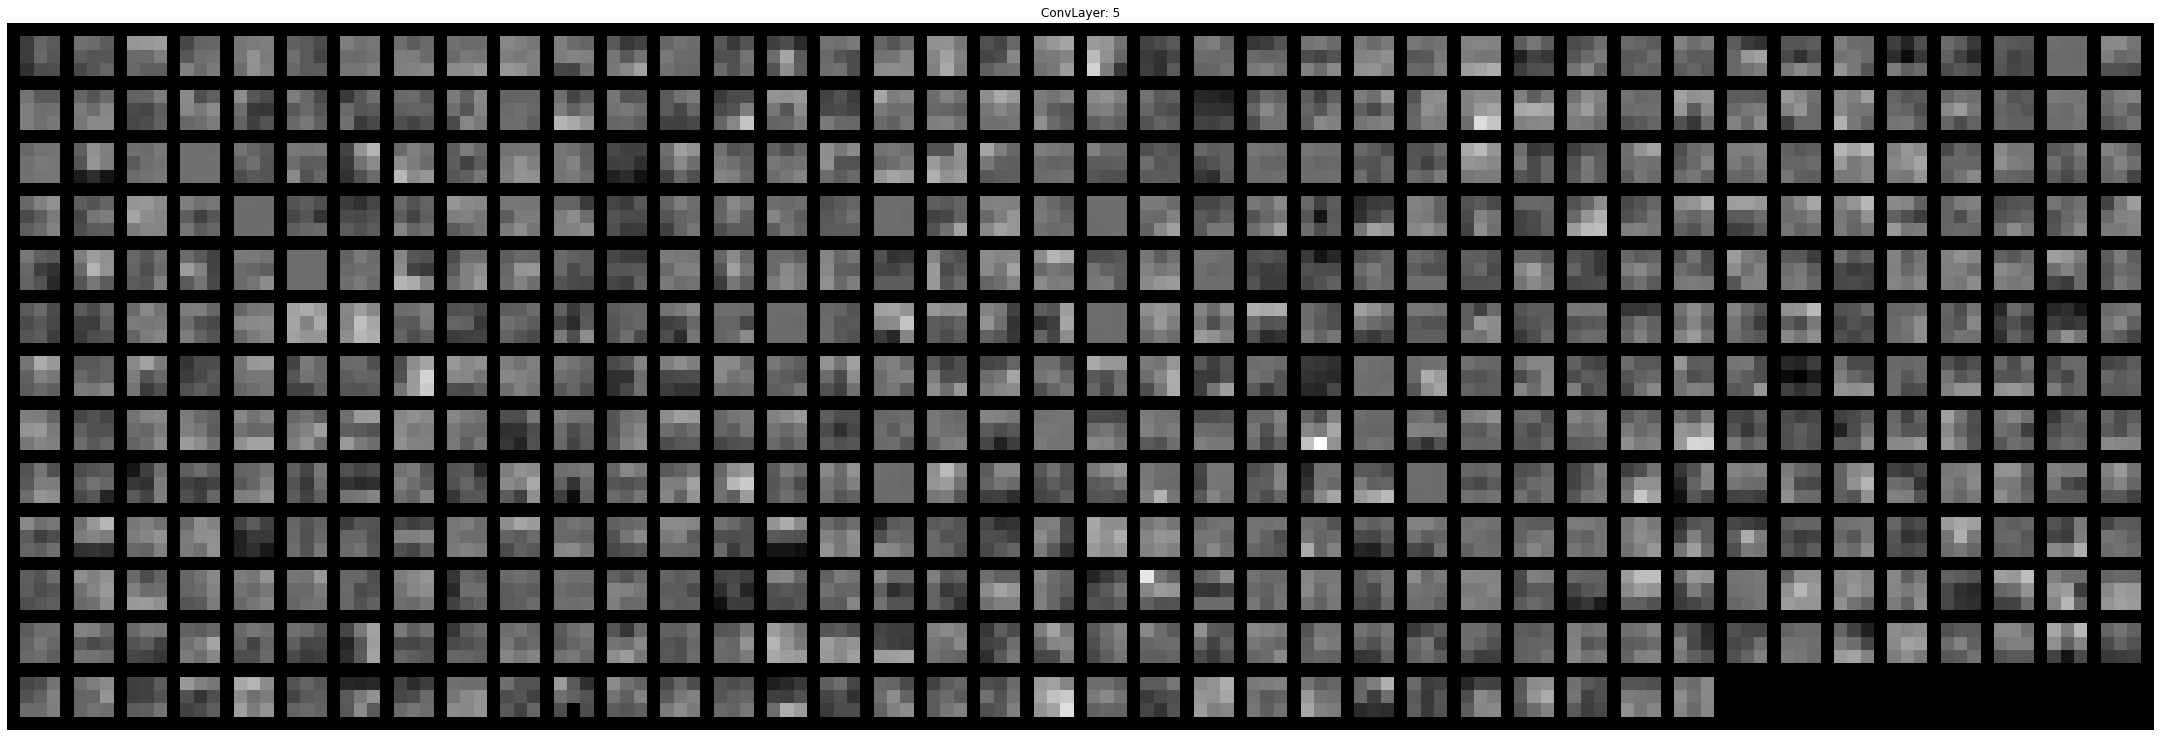

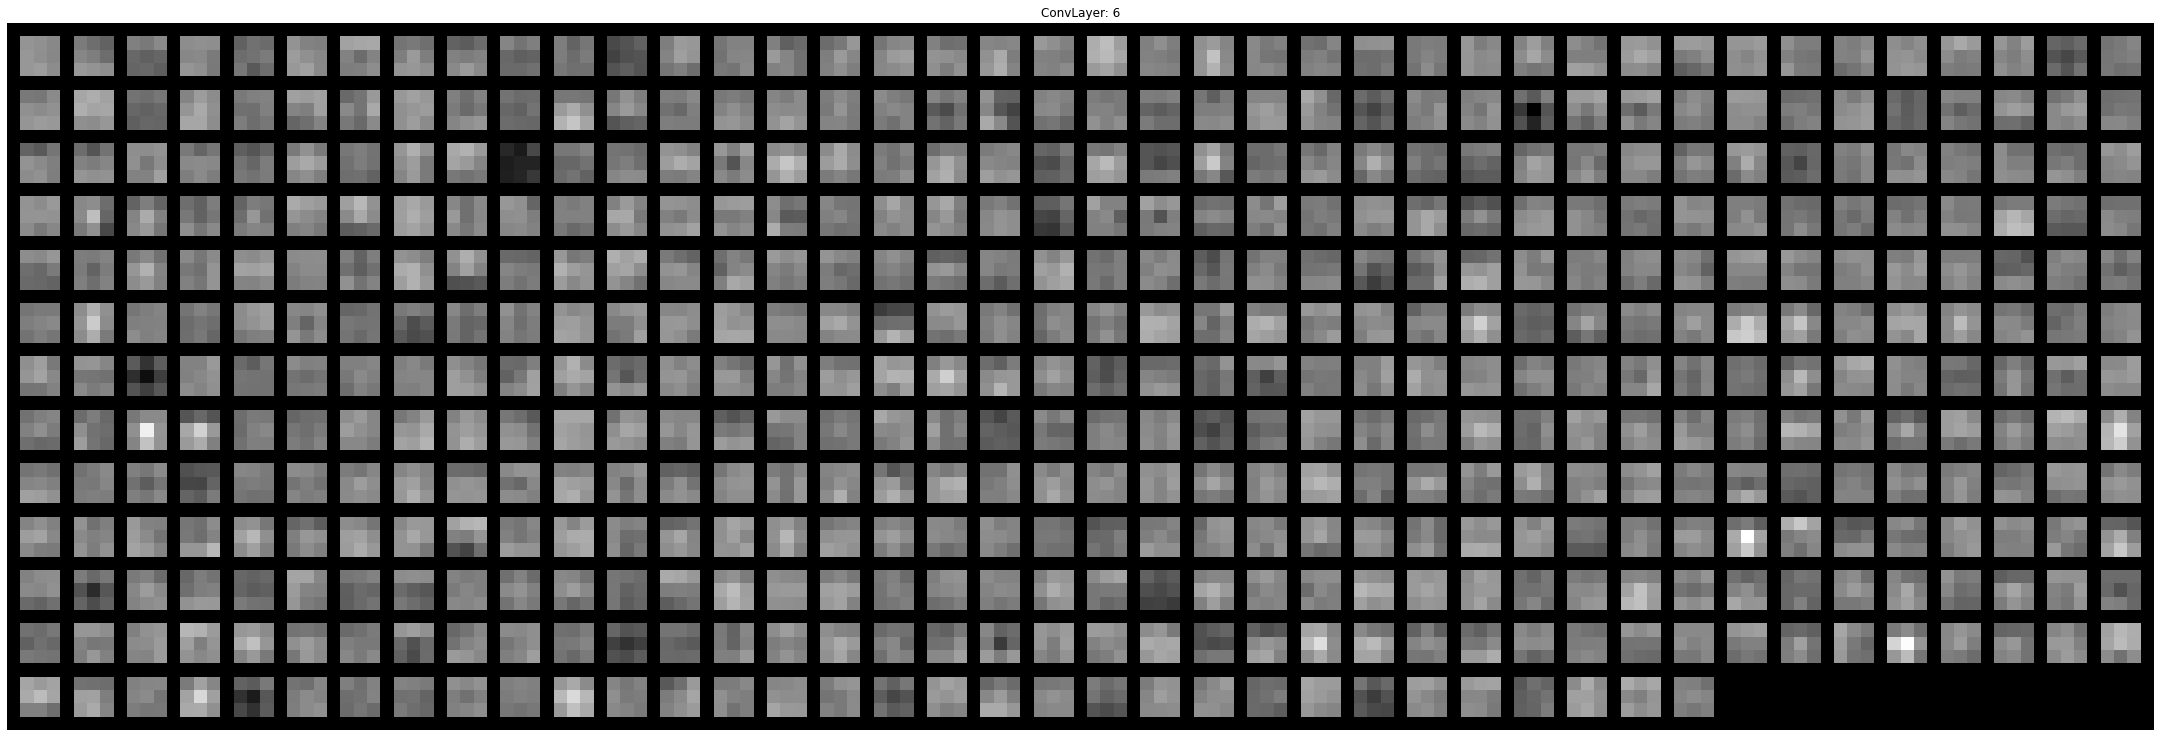

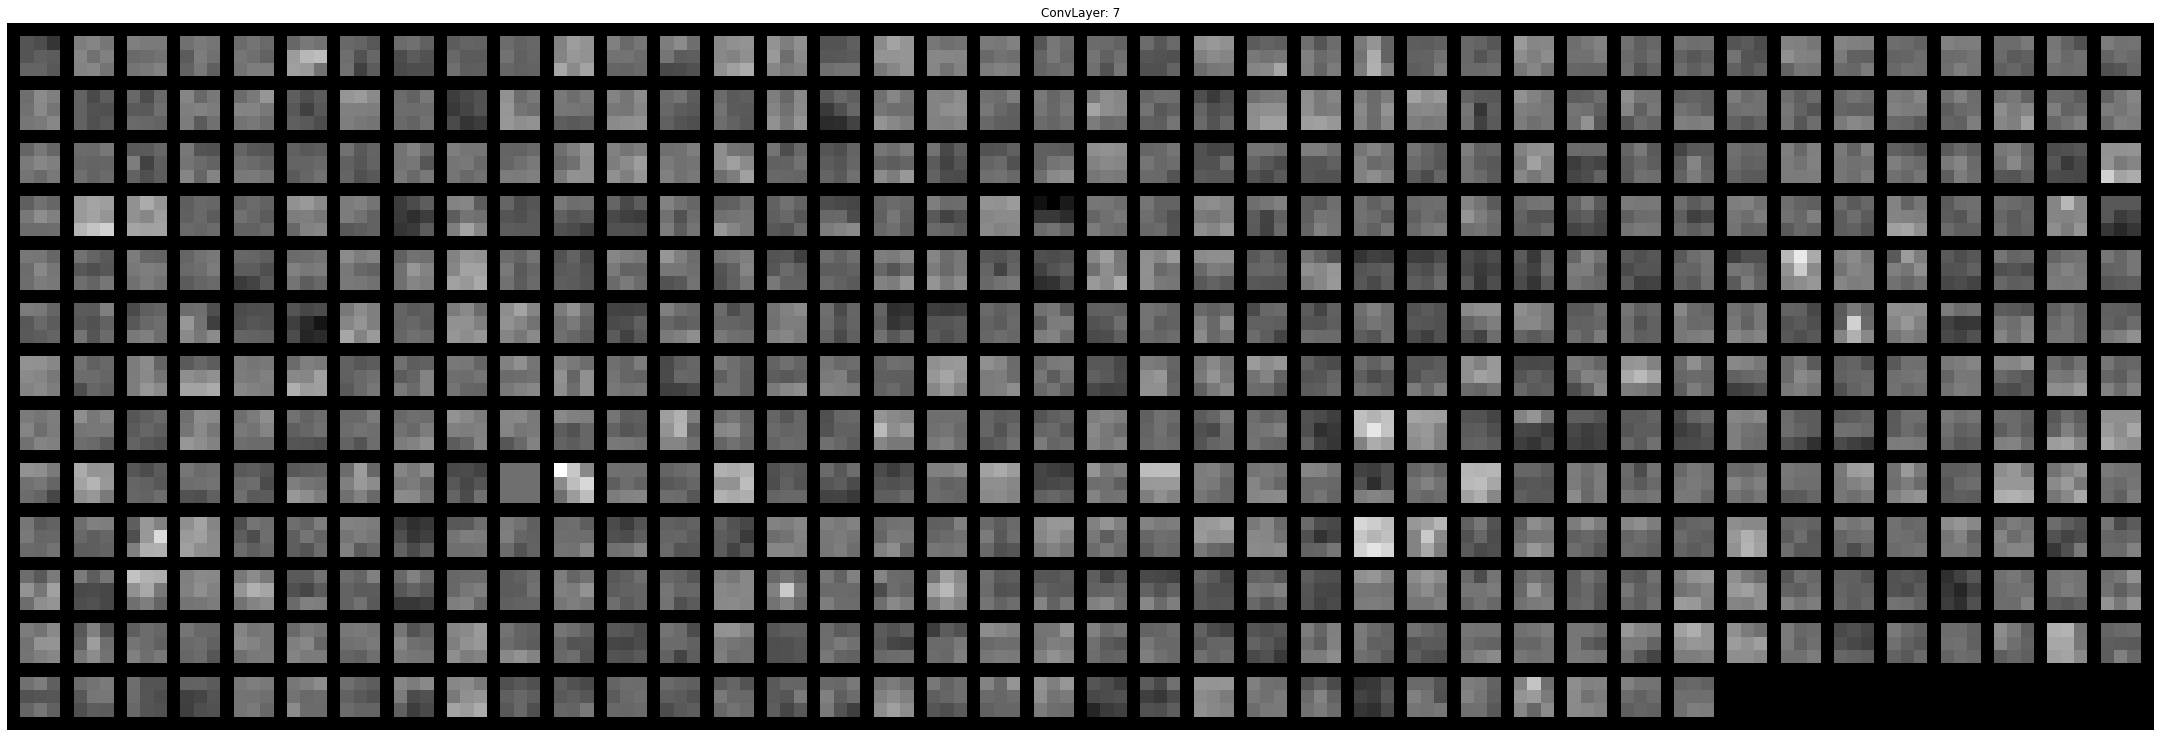

In [ ]:
def visTensor(tensor, ch=0, allkernels=False, nrow=40, padding=1): 
  n,c,w,h = tensor.shape

  if allkernels: tensor = tensor.view(n*c, -1, w, h)
  elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

  rows = np.min((tensor.shape[0] // nrow + 1, 64))    
  grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
  plt.figure( figsize=(nrow,rows) )
  plt.imshow(grid.numpy().transpose((1, 2, 0)))

%matplotlib inline
model_children = list(model.children())

layer = 0
for conv_layer in conv_layers:
  filter = conv_layer.weight.detach().clone().cpu()

  visTensor(filter.cpu(), ch=0, allkernels=False)
  shape = list(filter.shape)
  plt.title(f"ConvLayer: {layer}")
  plt.axis('off')
  plt.ioff()
  plt.show()
  layer += 1


# Visualize Activations (To-DO)

In [ ]:
# sample image
dataiter = iter(testloader)
images, labels = next(dataiter)

In [ ]:

results = [conv_layers[0](images.cuda())]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

Layer  1


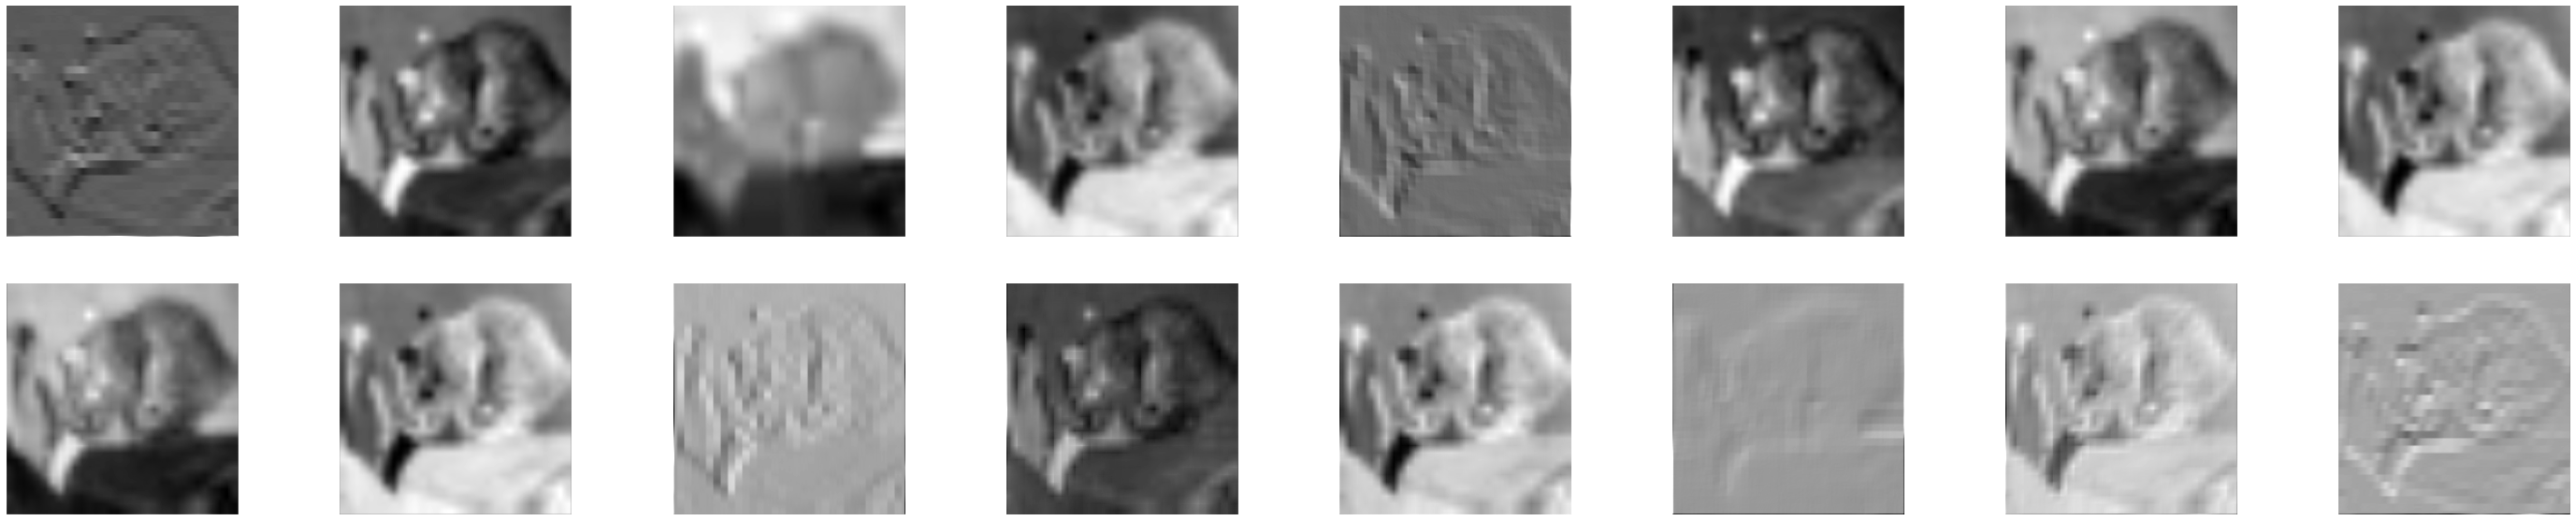

Layer  2


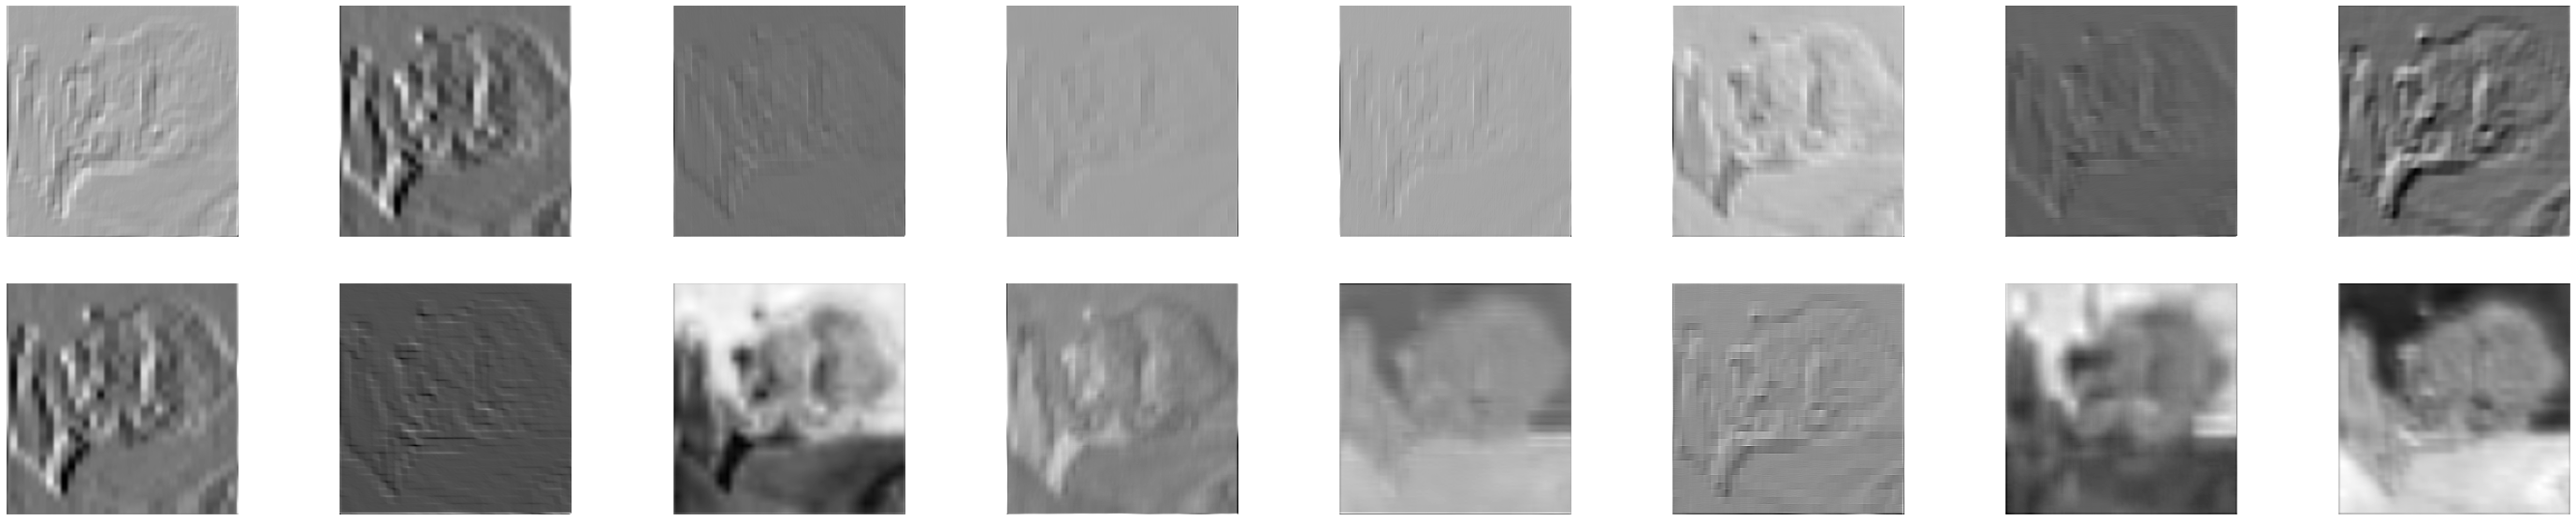

Layer  3


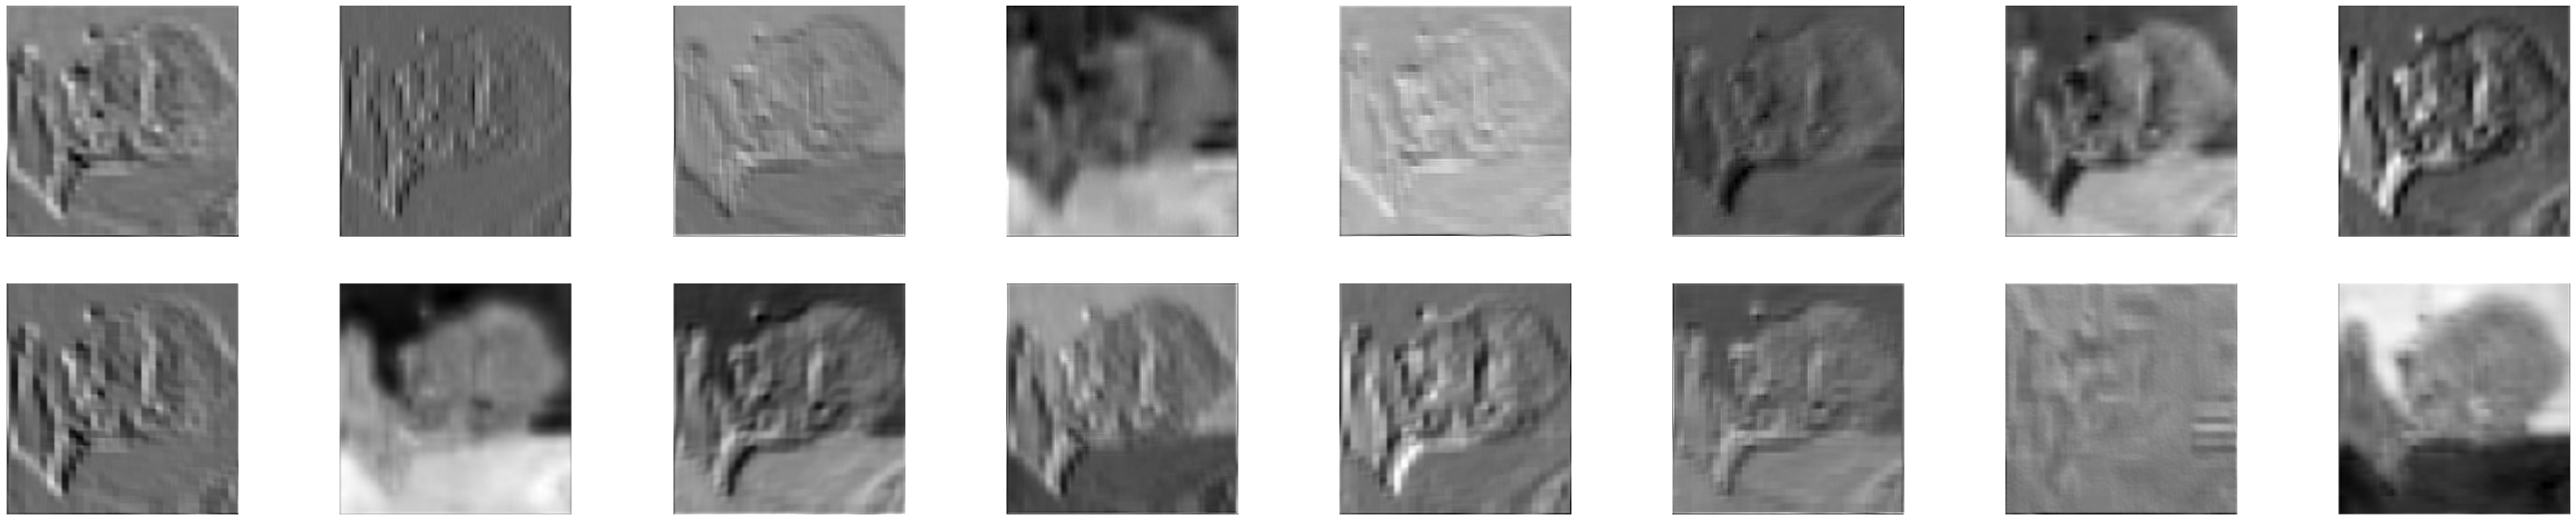

Layer  4


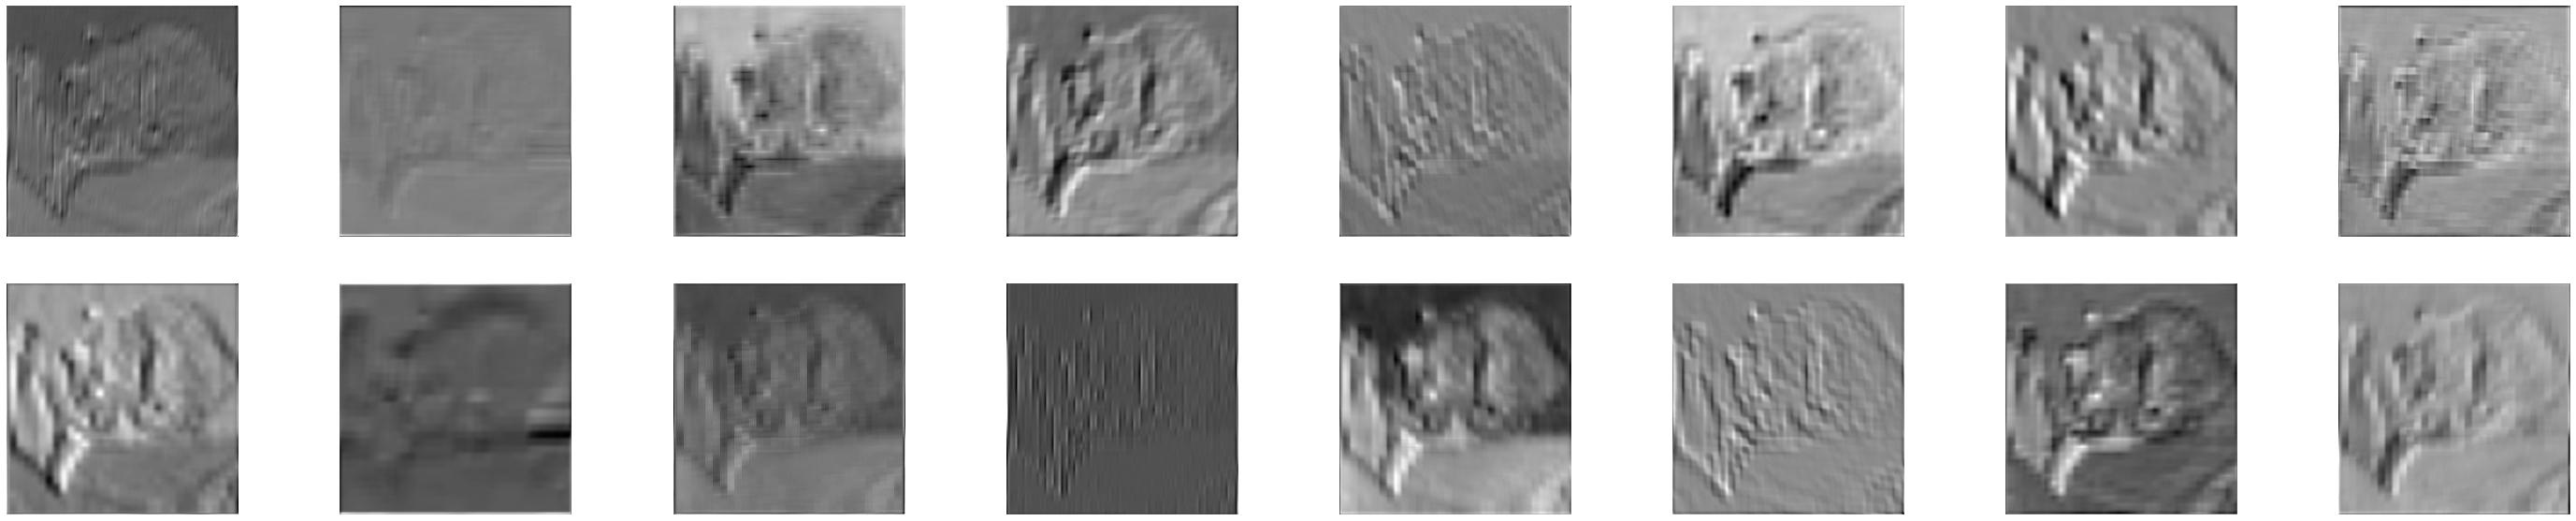

Layer  5


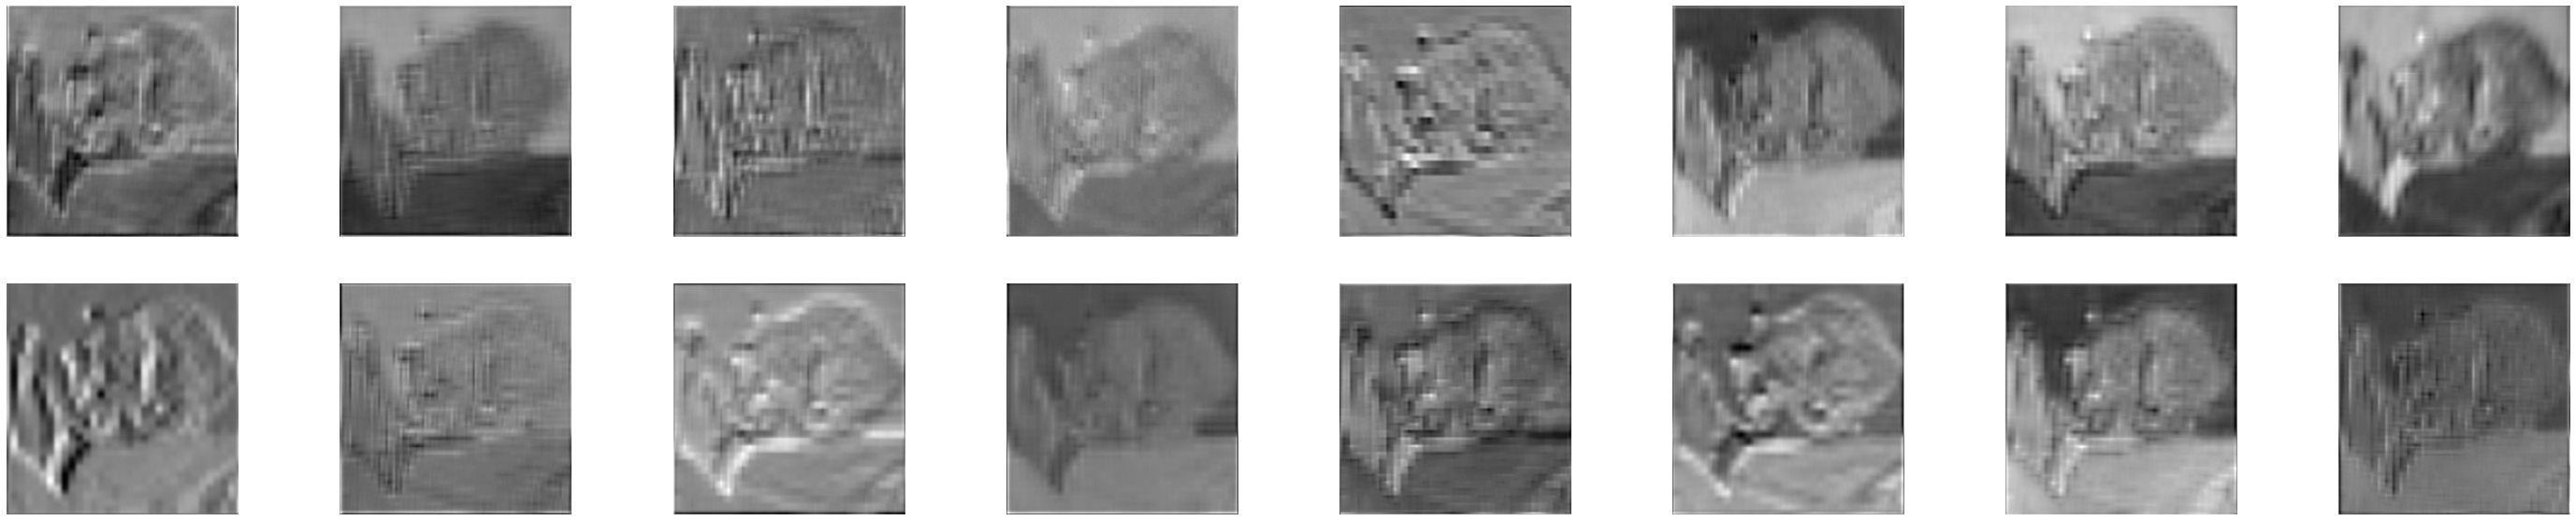

Layer  6


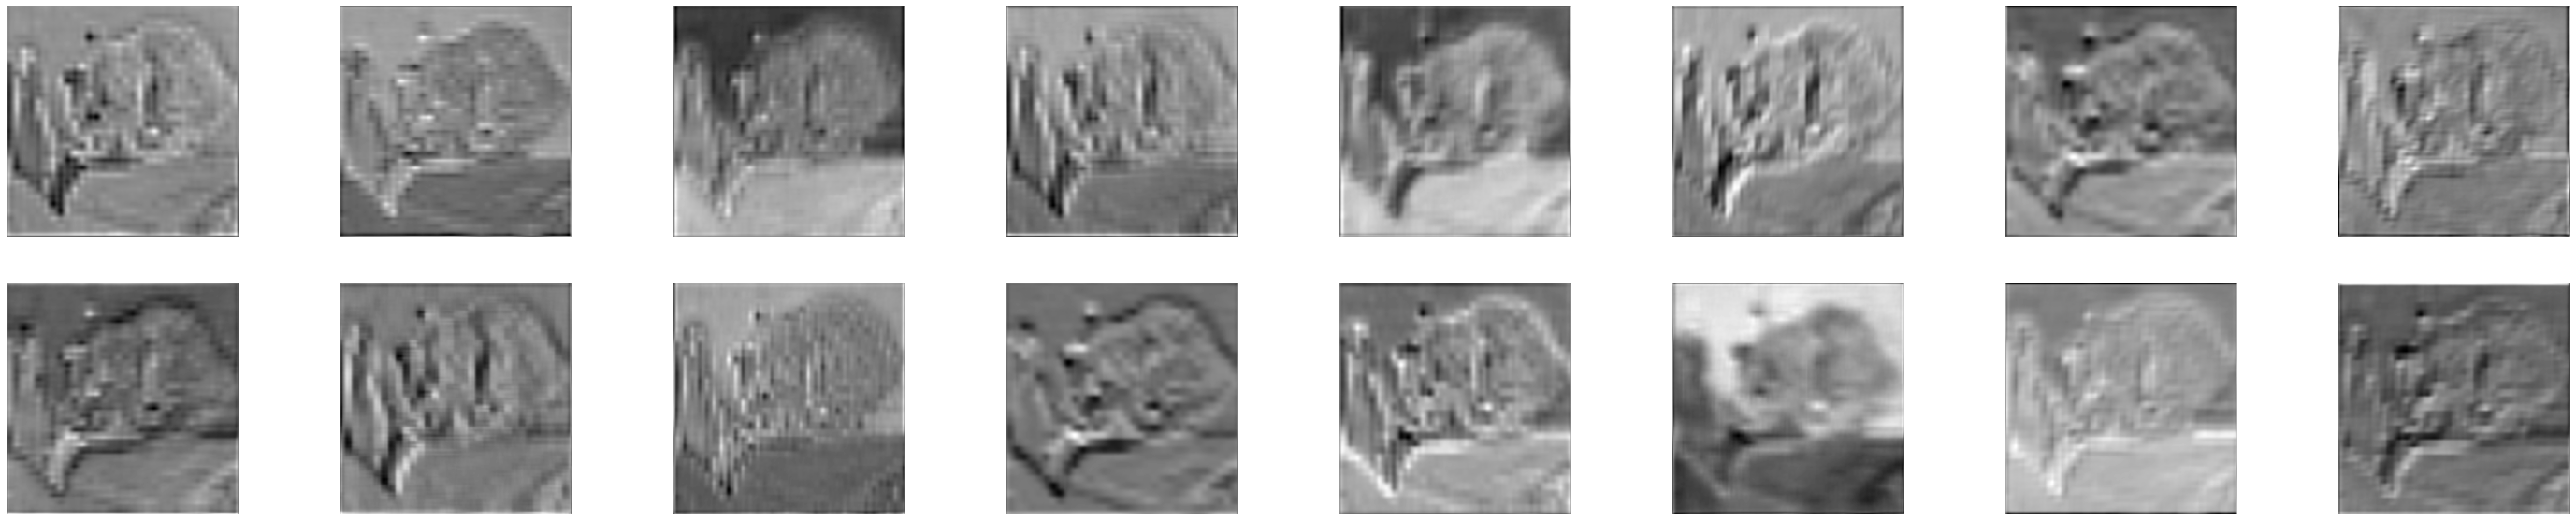

Layer  7


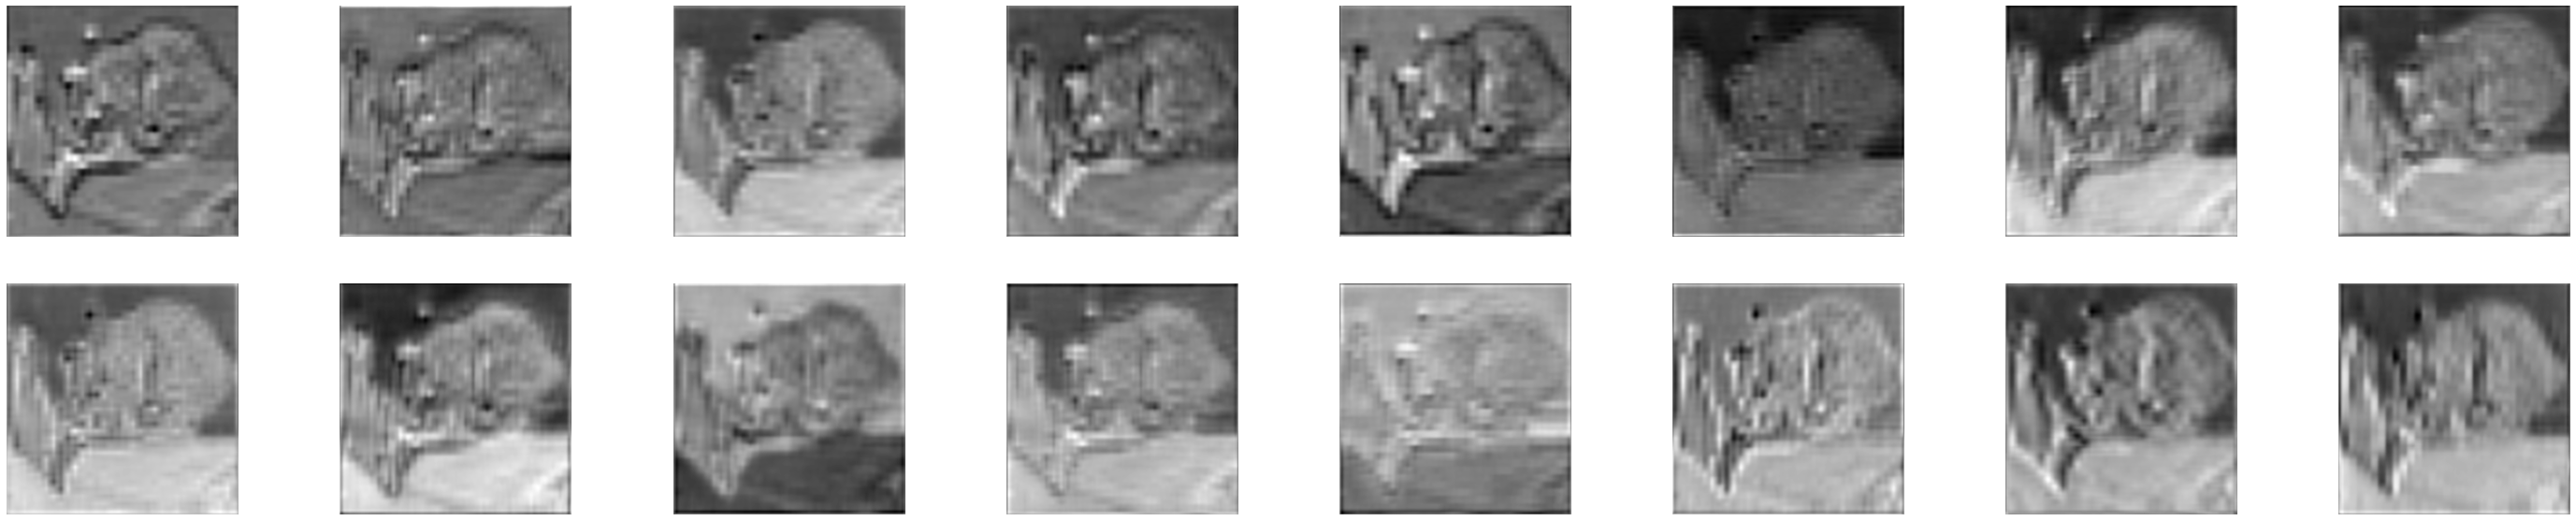

Layer  8


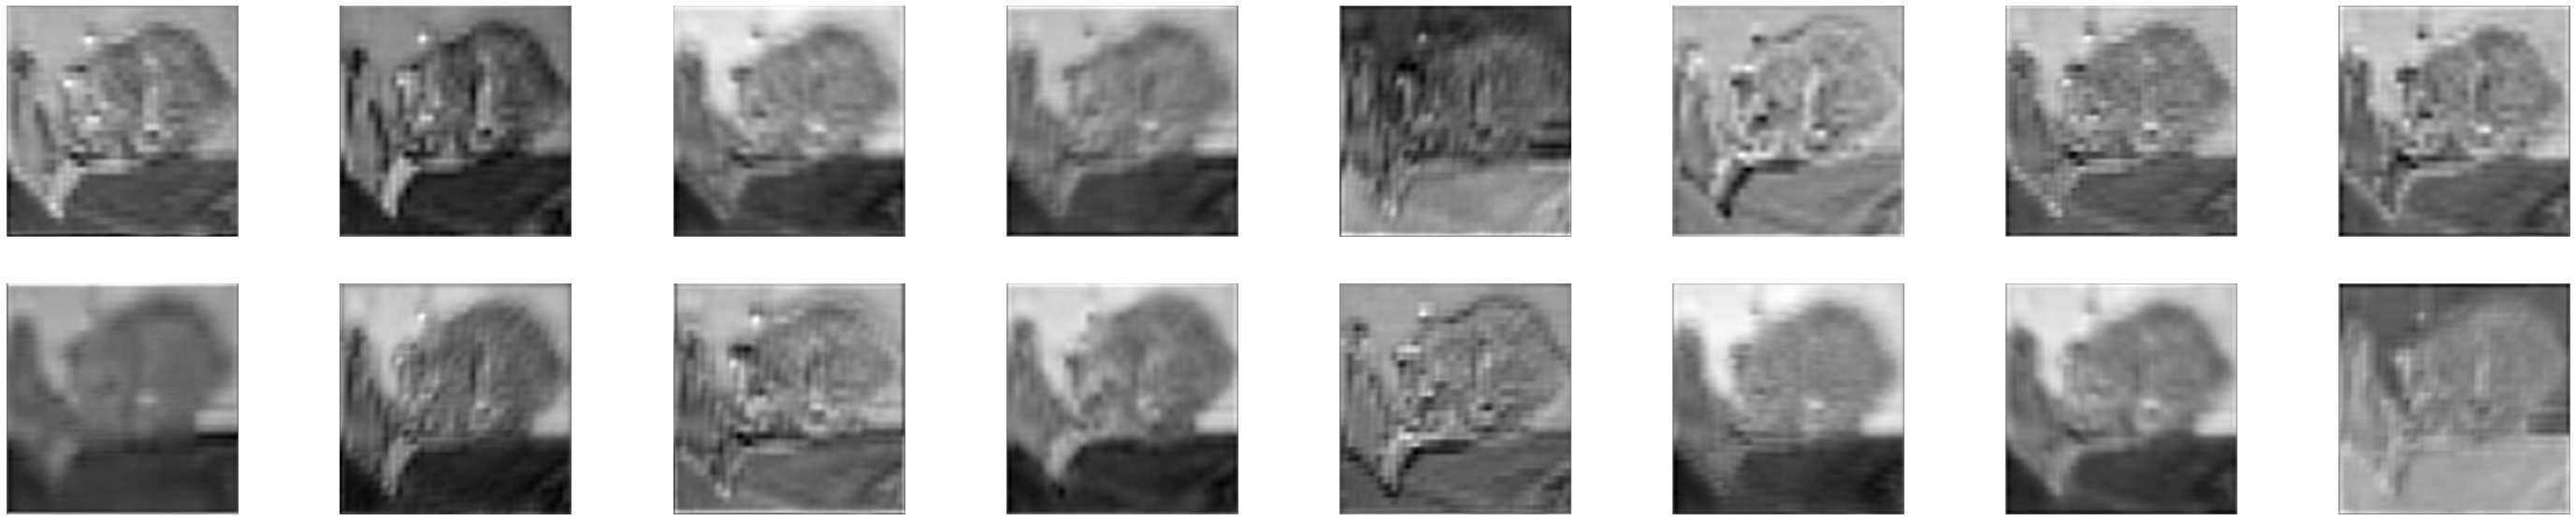

In [ ]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(50, 10))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print("Layer ",num_layer+1)
    for i, filter in enumerate(layer_viz):
        if i == 16: 
            break
        plt.subplot(2, 8, i + 1)
        plt.imshow(filter.cpu(), cmap='gray')
        plt.axis("off")
    plt.show()
    plt.close()